# Projet de Deep Learning :


=========== projet 6: prediction série temporelle =========

Nous considérons une série temporelle financière donnée de longueur totale N, S_t, t=0,1,...,N.
Nt=0.8*N (entrainement), Nv=0.2*N (validation) à télécharger sur internet ou à prendre une colonne dans 
https://turinici.com/wp-content/uploads/cours/common/close_cac40_historical.csv

Exemple N=255*10 (10 années de données journalières)

On calcule pour chaque point de la série initiale 
- les rendements R_t = np.log(X_t/X_{t-1})
- la moyenne des K derniers rendements, K=5 (=1 semaine: 1W), K=25 (1 mois: 1M), K=3*25 (3M); K=6*25 (6M), K=255 (1Y), K=3Y
- la volatilité (annualisée) des K derniers rendements sur la même période

On ajoute pour chaque point : 
- les calculs précédents (1+7*2 = 15 données)
- le prix en 't', (1 donnée)
- la moyenne exponentielle (EMA) des derniers K prix divisé par le prix en t (7 données)
- une fenetre de longueur "n" des prix S_{t-n} ... S_t,  par exemple n=3*25 (3 mois) : n données .

Attention: parfois il n'est pas possible de calculer par exemple la moyenne sur les 3 dernières année car pas assez de données. Alors la prendre égale à la plus longue qu'il est possible de calculer (ne pas mettre "nan").

Donc la base de données contient N-1 points.
A prevoir: le rendement suivant en R_{t+1}


In [ ]:
# 0) Chargement des bibliothèques + seed
# --------------------------------------

import numpy as np
import pandas as pd
import pandas_ta as ta

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os

# Pour la régression linéaire
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# Pour le réseau de neurones (Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from tabulate import tabulate

# Fixation du seed pour la reproductibilité
SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("Libraries loaded and random seed fixed.")


Libraries loaded and random seed fixed.


# 1) Lecture des données (depuis l'URL) et prétraitement

In [7]:
# ------------------------------------------------------

# URL des données
url = "https://turinici.com/wp-content/uploads/cours/common/close_cac40_historical.csv"

# Lecture du fichier CSV en ne chargeant que la colonne 'BNP.PA'
df_raw = pd.read_csv(url, sep=";", usecols=["Date", "BNP.PA"])

# Renommage des colonnes 
df_raw.rename(columns={"BNP.PA": "Price"}, inplace=True)

# Conversion de la colonne 'Date' en format datetime (si ce n'est pas déjà le cas)
df_raw['Date'] = pd.to_datetime(df_raw['Date'])

# Définir la colonne 'Date' comme index
df_raw.set_index("Date", inplace=True)

# Affichage des premières lignes et dimensions
print("\nAperçu des premières lignes :")
display(df_raw.head())
print("\nDimensions initiales :", df_raw.shape)

# Retirer les lignes contenant des NaN dans la colonne 'Price'
df_raw.dropna(subset=["Price"], inplace=True)

# Tri par index (date) pour s'assurer de l'ordre chronologique
df_raw.sort_index(inplace=True)

# Vérification après nettoyage
print("\nAperçu après nettoyage :")
display(df_raw.head())
print("\nDimensions après nettoyage :", df_raw.shape)




Aperçu des premières lignes :


,Price
Date,
2000-01-03,16.165972
2000-01-04,15.711578
2000-01-05,15.379528
2000-01-06,14.855226
2000-01-07,15.047465



Dimensions initiales : (8605, 1)

Aperçu après nettoyage :


,Price
Date,
1993-10-18,4.227787
1993-10-19,4.120383
1993-10-20,4.149676
1993-10-21,4.218023
1993-10-22,4.315662



Dimensions après nettoyage : (7339, 1)


# 2) Feature Engineering

In [8]:
# ----------------------
# - Calcul des rendements log (R_t = log(X_t / X_{t-1}))
# - Moyennes mobiles sur K jours, volatilités annualisées
# - EMA (Exponentially Moving Average) / Price
# - Fenêtre glissante n = 3 * 25

df = df_raw.copy()

# 2.1 Rendement log
df["Return"] = np.log(df["Price"] / df["Price"].shift(1))
df.dropna(inplace=True)  # retire la première ligne NaN

# 2.2 Définition des horizons K
K_list = [5, 25, 75, 150, 252, 3*252]  # 1W, 1M, 3M, 6M, 1Y, 3Y
# Filtrons si la base est trop courte pour calculer 3 ans
K_list = [K for K in K_list if K < len(df)]

# Calculs (moyenne mobile des rendements + volatilité annualisée)
for K in K_list:
    # Moyenne des K derniers rendements
    df[f"meanRet_{K}"] = df["Return"].rolling(K).mean()
    df[f"meanRet_{K}"].fillna(method="bfill", inplace=True)

    # Volatilité annualisée sur K derniers rendements
    df[f"vol_{K}"] = df["Return"].rolling(K).std() * np.sqrt(252)
    df[f"vol_{K}"].fillna(method="bfill", inplace=True)


# 2.4 EMA(K) / Price
for K in K_list:
    ema_series = df["Price"].ewm(span=K, adjust=False).mean()
    df[f"emaRatio_{K}"] = ema_series / df["Price"]
    df[f"emaRatio_{K}"].fillna(method="bfill", inplace=True)

# 2.5 Fenêtre glissante
n = 25 * 3
for i in range(n):
    df[f"Price_lag_{i+1}"] = df["Price"].shift(i+1)

df.dropna(inplace=True)

# 2.6 Cible = Rendement futur R_{t+1}

df["FutureReturn"] = df["Return"].shift(-1)
df.dropna(inplace=True)

print(f"\nDimensions après feature engineering : {df.shape}")

# 2.7 Sélection des features (X) et de la cible (y)
exclude_cols = ["Price", "Return", "FutureReturn"]
feature_cols = [c for c in df.columns if c not in exclude_cols]
X = df[feature_cols].values
y = df["FutureReturn"].values

# 2.8 Normalisation (StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Feature scaling terminé.")





Dimensions après feature engineering : (7262, 96)
Feature scaling terminé.


/var/folders/3_/t8l3yh8s28z9_jbq7gqy7byr0000gn/T/ipykernel_48432/933299551.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[f"meanRet_{K}"].fillna(method="bfill", inplace=True)
/var/folders/3_/t8l3yh8s28z9_jbq7gqy7byr0000gn/T/ipykernel_48432/933299551.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[f"meanRet_{K}"].fillna(method="bfill", inplace=True)
/var/folders/3_/t8l3yh8s28z9_jbq7gqy7byr0000gn/T/ipykernel_48432/933299551.

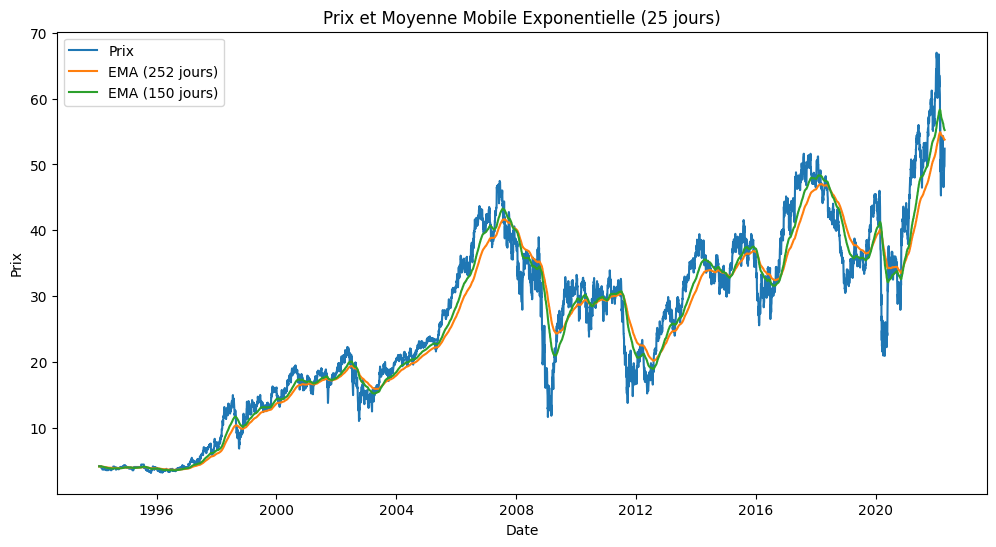

In [9]:
# Exemple de visualisation : prix et EMA

plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Price"], label="Prix")
plt.plot(df.index, df["Price"] * df["emaRatio_252"], label="EMA (252 jours)")
plt.plot(df.index, df["Price"] * df["emaRatio_150"], label="EMA (150 jours)")
plt.title("Prix et Moyenne Mobile Exponentielle (25 jours)")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.show()


# 3) Séparation temporelle (Train=80%, Test=20%)


In [10]:
# ----------------------------------------------
N = len(df)
Nt = int(0.8 * N)   # Nt := N_Train
Nv = N - Nt # Nv := N_Test

X_train, X_test = X_scaled[:Nt], X_scaled[Nt:]
y_train, y_test = y[:Nt], y[Nt:]

print("\nTaille dataset complet :", N)
print("Taille train :", Nt)
print("Taille test :", Nv)


Taille dataset complet : 7262
Taille train : 5809
Taille test : 1453


# 4.1) Modèle de Regression Linéaire 

In [11]:
# Régression linéaire
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_lin = linreg.predict(X_test)

# Évaluation des performances
mse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
print(f"\nRégression Linéaire - RMSE test : {mse_lin:.6f}")



Régression Linéaire - RMSE test : 0.021756


In [12]:
# Calcul de l'erreur
errors = np.array(y_test) - np.array(y_pred_lin)

# Création de la figure interactive
fig = go.Figure()

# Ajout des vrais rendements
fig.add_trace(go.Scatter(
    x=list(range(len(y_test))),
    y=y_test,
    mode='lines+markers',
    name='Vrais rendements (Réels)',
    line=dict(color='blue', dash='solid'),
    marker=dict(symbol='circle'),
    opacity=0.7
))

# Ajout des prédictions
fig.add_trace(go.Scatter(
    x=list(range(len(y_pred_lin))),
    y=y_pred_lin,
    mode='lines+markers',
    name='Prédictions (Régression Linéaire)',
    line=dict(color='red', dash='dash'),
    marker=dict(symbol='x'),
    opacity=0.7
))

# Ajout des erreurs
fig.add_trace(go.Scatter(
    x=list(range(len(errors))),
    y=errors,
    mode='lines+markers',
    name='Erreur (Vrais - Prédictions)',
    line=dict(color='green', dash='dot'),
    marker=dict(symbol='triangle-up'),
    opacity=0.7
))

# Mise en forme de la figure
fig.update_layout(
    title="Vrais rendements VS Prédictions et Erreur (Régression Linéaire)",
    xaxis_title="Index Chronologique",
    yaxis_title="Rendement",
    legend=dict(font=dict(size=12)),
    grid=dict(rows=1, columns=1),
    template="plotly_white"
)

# Affichage de la figure
fig.show()


# 4.1) Modèle de Regression Linéaire Pénalisation Lasso

In [15]:
lasso = Lasso(alpha=0.01)  
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

# Évaluation des performances pour Lasso
mse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
print(f"\nRégression Lasso - RMSE test : {mse_lasso:.6f}")

'''print("\nComparaison des coefficients :")
print("Régression Linéaire :", linreg.coef_)
print("Régression Lasso :", lasso.coef_)'''

coefficients_linreg = pd.Series(linreg.coef_, index=df[feature_cols].columns)
coefficients_linreg = coefficients_linreg.abs()
coefficients_linreg = coefficients_linreg.sort_values(ascending=False)
coefficients_lasso = pd.Series(lasso.coef_, index=df[feature_cols].columns)
coefficients_lasso = coefficients_lasso.abs()
coefficients_lasso = coefficients_lasso.sort_values(ascending=False)
print("Important features in the linear regression :",coefficients_linreg)
print("Important features in the lasso regression :",coefficients_lasso)


Régression Lasso - RMSE test : 0.021108
Important features in the linear regression : emaRatio_150    0.056147
Price_lag_26    0.051277
Price_lag_45    0.044995
Price_lag_3     0.041576
emaRatio_75     0.038274
                  ...   
vol_25          0.000361
meanRet_756     0.000306
meanRet_150     0.000213
Price_lag_34    0.000176
meanRet_25      0.000028
Length: 93, dtype: float64
Important features in the lasso regression : meanRet_5       0.0
Price_lag_42    0.0
Price_lag_51    0.0
Price_lag_50    0.0
Price_lag_49    0.0
               ... 
Price_lag_12    0.0
Price_lag_11    0.0
Price_lag_10    0.0
Price_lag_9     0.0
Price_lag_75    0.0
Length: 93, dtype: float64


# 4.2) Modèle Random Forest

In [32]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)  
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Évaluation des performances pour Random Forest
mse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"\nRégression Random Forest - RMSE test : {mse_rf:.6f}")

# Comparaison des importances des features pour Random Forest
importances_rf = rf.feature_importances_

feat = {}
#print("\nImportance des features (Random Forest) :")
for name, importance in zip(feature_cols, importances_rf):
    #print(f"{name}: {importance:.4f}")
    feat[name] = importance
coefficients_rf = pd.Series(feat)
print("Important features in Random Forest :",coefficients_rf)

KeyboardInterrupt: 

In [30]:
headers = ['Model','MSE']
data = [['MSE LR',mse_lin],['MSE Lasso',mse_lasso],['MSE RF',mse_rf]]
print(tabulate(data, headers, tablefmt="grid"))

+-----------+-----------+
| Model     |       MSE |
+===========+===========+
| MSE LR    | 0.0217564 |
+-----------+-----------+
| MSE Lasso | 0.0211079 |
+-----------+-----------+
| MSE RF    | 0.0231148 |
+-----------+-----------+


# 5.1) Pré-process pour passer les données en format séquentiels

Objectif : prédire un interval auquel appartient le return, utilisation du papier LLM de Brugiere et Turinici

In [ ]:
n_buckets = 7
quantiles = np.linspace(0, 1, n_buckets+1)  
cuts = df['FutureReturn'].quantile(quantiles).values

print("Cut edges (quantiles):", cuts)

df['FutureReturn_bucket'] = pd.cut(
    df['FutureReturn'],
    bins=cuts,            
    labels=False,         
    include_lowest=True   
)

exclude_cols = ["Price", "Return", "FutureReturn", "FutureReturn_bucket"]
feature_cols = [c for c in df.columns if c not in exclude_cols]
X = df[feature_cols].values
y = df["FutureReturn_bucket"].values.astype(int)  

N = len(df)
Nt = int(0.8 * N)
Nv = N - Nt

X_train, X_test = X[:Nt], X[Nt:]
y_train, y_test = y[:Nt], y[Nt:]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

seq_length = 35

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, seq_length)
X_test_seq,  y_test_seq  = create_sequences(X_test_scaled,  y_test,  seq_length)

print(f"Forme X_train_seq : {X_train_seq.shape}")
print(f"Forme y_train_seq : {y_train_seq.shape}")

y_train_cat = to_categorical(y_train_seq, num_classes=n_buckets)
y_test_cat  = to_categorical(y_test_seq,  num_classes=n_buckets)

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)



Cut edges (quantiles): [-0.19116565 -0.01847911 -0.00820182 -0.00163373  0.00193319  0.00858055
  0.01926849  0.18874477]
Forme X_train_seq : (5774, 35, 95)
Forme y_train_seq : (5774,)


# 6) Modèle LSTM 

Définition du modèle et des couches avec le Dropout 

In [141]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(seq_length, X_train_seq.shape[2])),
    tf.keras.layers.LSTM(64, return_sequences=True, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(64, return_sequences=False, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(n_buckets, activation='softmax')  
])

model_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model_lstm.summary()


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 35, 64)         │        40,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_89 (Dropout)            │ (None, 35, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_90 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,295 (298.03 KB)

 Trainable params: 76,295 (298.03 KB)

 Non-trainable params: 0 (0.00 B)

Train du modèle LSTM

In [142]:
history_lstm = model_lstm.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=10,
    batch_size=32,
    verbose=1
)


Epoch 1/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - accuracy: 0.2145 - loss: 1.9295 - val_accuracy: 0.1968 - val_loss: 1.8938
Epoch 2/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.2451 - loss: 1.8240 - val_accuracy: 0.1890 - val_loss: 1.8969
Epoch 3/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.2531 - loss: 1.8070 - val_accuracy: 0.1848 - val_loss: 1.8932
Epoch 4/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.2534 - loss: 1.7917 - val_accuracy: 0.1918 - val_loss: 1.8975
Epoch 5/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.2515 - loss: 1.7893 - val_accuracy: 0.1918 - val_loss: 1.8959
Epoch 6/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.2667 - loss: 1.7789 - val_accuracy: 0.1897 - val_loss: 1.9476
Epoch 7/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.2655 - loss: 1.7753 - val_accuracy: 0.1890 - val_loss: 1.9153
Epoch 8/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.2618 - loss: 1.7756 - 

Evaluation du modèle LSTM 

In [143]:
test_loss, test_acc = model_lstm.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f"\nTest loss (cross-entropy) : {test_loss:.4f}")
print(f"Test accuracy             : {test_acc:.2%}")
y_proba = model_lstm.predict(X_test_seq)
predicted_buckets = np.argmax(y_proba, axis=1)



Test loss (cross-entropy) : 1.8933
Test accuracy             : 18.05%
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step


Graph de la distribution réelle VS distribution prédite par Bucket 

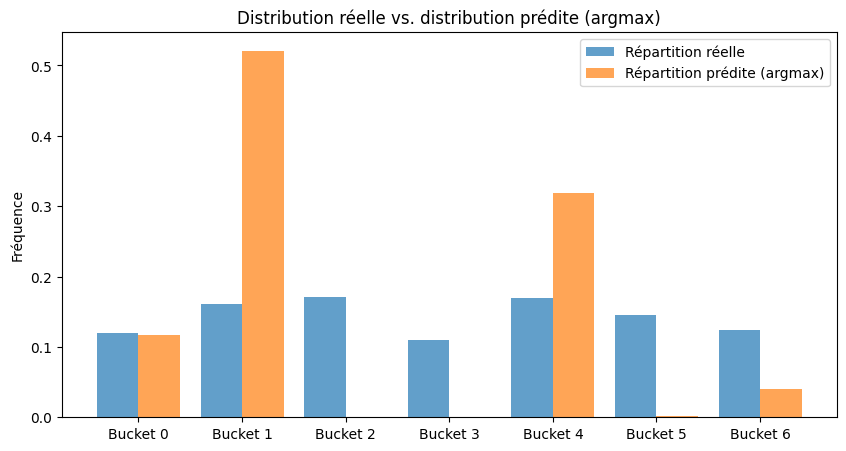

In [144]:

# y_test_seq : tableaux d'entiers 0..(n_buckets-1) indiquant le bucket réel
# y_proba    : prédictions de taille (N_test, n_buckets)
#             => pour chaque exemple, y_proba[i,j] = proba prédite du bucket j
# predicted_buckets : argmax(y_proba, axis=1)

true_counts = np.bincount(y_test_seq, minlength=n_buckets)
predicted_buckets = np.argmax(y_proba, axis=1)
pred_counts = np.bincount(predicted_buckets, minlength=n_buckets)

# Convertit en fréquences (somme à 1)
true_freq = true_counts / true_counts.sum()
pred_freq = pred_counts / pred_counts.sum()

plt.figure(figsize=(10,5))
bar_width = 0.4
indices = np.arange(n_buckets)

plt.bar(indices - bar_width/2, true_freq, width=bar_width, alpha=0.7, label="Répartition réelle")
plt.bar(indices + bar_width/2, pred_freq, width=bar_width, alpha=0.7, label="Répartition prédite (argmax)")

plt.xticks(indices, [f"Bucket {i}" for i in indices])
plt.ylabel("Fréquence")
plt.legend()
plt.title("Distribution réelle vs. distribution prédite (argmax)")
plt.show()


Permet de regarder si les classes sont prédites avec des poids similaires et équilibrés

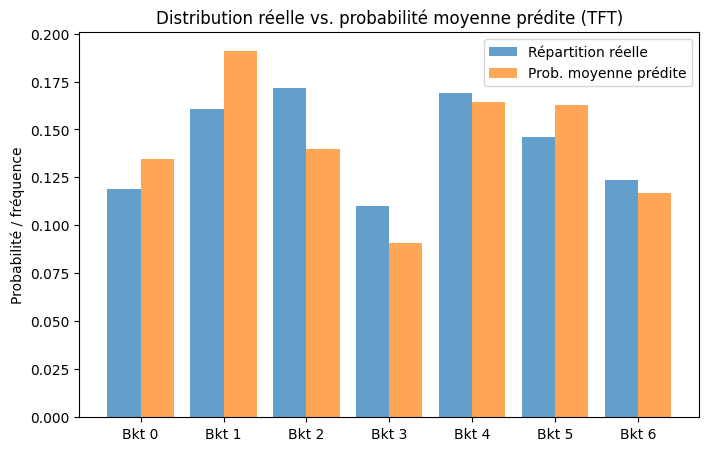

In [145]:
mean_proba = y_proba.mean(axis=0)  

plt.figure(figsize=(8,5))
plt.bar(indices - bar_width/2, true_freq, width=bar_width, alpha=0.7, label="Répartition réelle")
plt.bar(indices + bar_width/2, mean_proba, width=bar_width, alpha=0.7, label="Prob. moyenne prédite")
plt.xticks(indices, [f"Bkt {i}" for i in indices])
plt.ylabel("Probabilité / fréquence")
plt.title("Distribution réelle vs. probabilité moyenne prédite (TFT)")
plt.legend()
plt.show()


Evolution de la Loss pour le train et le test

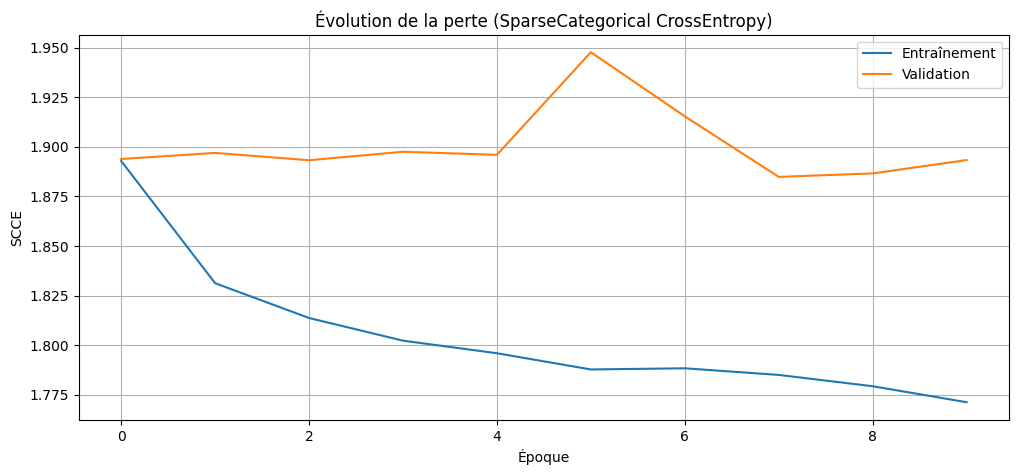

In [146]:
# Courbes d'entraînement et de validation
plt.figure(figsize=(12, 5))
plt.plot(history_lstm.history['loss'], label='Entraînement')
plt.plot(history_lstm.history['val_loss'], label='Validation')
plt.title('Évolution de la perte (SparseCategorical CrossEntropy)')
plt.xlabel('Époque')
plt.ylabel('SCCE')
plt.legend()
plt.grid(True)
plt.show()

Bucket means (approximations des retours) : [-0.10482238338128039, -0.013340465964670367, -0.004917772413509096, 0.00014973223359751034, 0.005256868723681023, 0.013924518982758632, 0.1040066304792873]


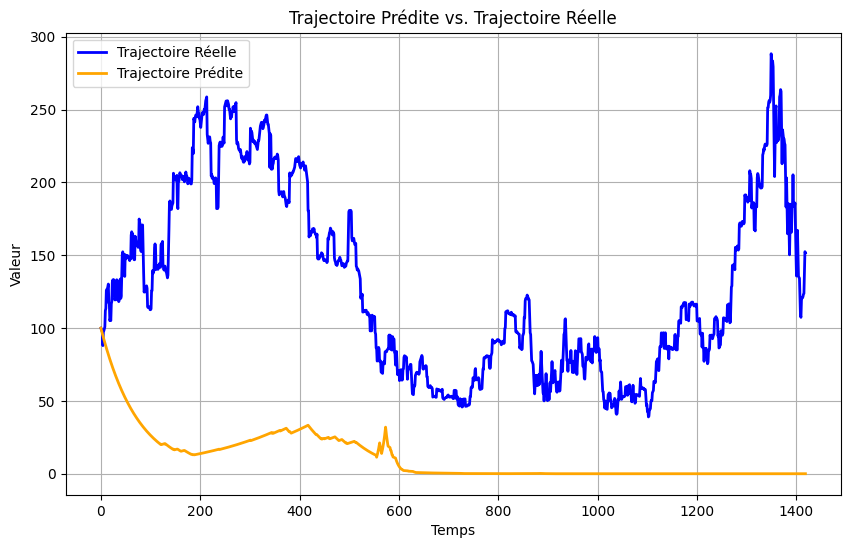

In [154]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Définir les valeurs centrales (ou moyennes) des buckets
# Supposons que vous ayez les bords des buckets comme `cuts`
# Calculer la moyenne de chaque bucket
bucket_means = [(cuts[i] + cuts[i+1]) / 2 for i in range(len(cuts) - 1)]
print("Bucket means (approximations des retours) :", bucket_means)

# 2. Reconstruire les trajectoires
initial_value = 100  # Valeur initiale pour les deux trajectoires

# Trajectoire réelle
true_returns = y_test_seq[:len(predicted_buckets)]  # Correspondance avec les buckets prédits
real_trajectory = [initial_value]
for r in true_returns:
    real_trajectory.append(real_trajectory[-1] * np.exp(bucket_means[r]))

# Trajectoire prédite
predicted_trajectory = [initial_value]
for p in predicted_buckets:
    predicted_trajectory.append(predicted_trajectory[-1] * np.exp(bucket_means[p]))

# 3. Tracer les trajectoires
plt.figure(figsize=(10, 6))
plt.plot(real_trajectory, label="Trajectoire Réelle", linewidth=2, color="blue")
plt.plot(predicted_trajectory, label="Trajectoire Prédite", linewidth=2, color="orange")
plt.title("Trajectoire Prédite vs. Trajectoire Réelle")
plt.xlabel("Temps")
plt.ylabel("Valeur")
plt.legend()
plt.grid()
plt.show()


# 7) TFT Modèle

Features engineering pour le modèle TFT on va ajouter des features :

-RSI
-MACD
-Bande de Bollinger
-Momentum et Rate Of Change (ROC)

In [157]:
# Copie du DataFrame original
df_TFT = df.copy()

# Ajout des indicateurs techniques
df_TFT["RSI_14"] = ta.rsi(df_TFT["Price"], length=14)

# Ajout du MACD
macd = ta.macd(df_TFT["Price"])
df_TFT["MACD"] = macd["MACD_12_26_9"]
df_TFT["MACD_Signal"] = macd["MACDs_12_26_9"]
df_TFT["MACD_Hist"] = macd["MACDh_12_26_9"]

# Ajout des Bandes de Bollinger
bbands = ta.bbands(df_TFT["Price"], length=20, std=2)
df_TFT["BB_Lower"] = bbands["BBL_20_2.0"]
df_TFT["BB_Mid"] = bbands["BBM_20_2.0"]
df_TFT["BB_Upper"] = bbands["BBU_20_2.0"]

# Ajout du Momentum et du ROC (Rate of Change)
df_TFT["Momentum_5"] = ta.mom(df_TFT["Price"], length=5) 
df_TFT["ROC_5"] = ta.roc(df_TFT["Price"], length=5)     


# Suppression des lignes NaN
df_TFT.dropna(inplace=True)

# Vérification et correction des types des colonnes (si nécessaire)
for col in ["RSI_14", "MACD", "MACD_Signal", "MACD_Hist", "BB_Lower", "BB_Mid", "BB_Upper", "Momentum_5", "ROC_5"]:
    df_TFT[col] = pd.to_numeric(df_TFT[col], errors='coerce')

# Suppression des lignes NaN après correction
df_TFT.dropna(inplace=True)



n_buckets = 7
quantiles = np.linspace(0, 1, n_buckets+1)  
cuts = df_TFT['FutureReturn'].quantile(quantiles).values

print("Cut edges (quantiles):", cuts)

df_TFT['FutureReturn_bucket'] = pd.cut(
    df_TFT['FutureReturn'],
    bins=cuts,            
    labels=False,         
    include_lowest=True   
)


exclude_cols = ["Price", "Return", "FutureReturn", "FutureReturn_bucket"]
feature_cols = [c for c in df.columns if c not in exclude_cols]
X = df_TFT[feature_cols].values
y = df_TFT["FutureReturn_bucket"].values.astype(int)  

N = len(df)
Nt = int(0.8 * N)
Nv = N - Nt

X_train, X_test = X[:Nt], X[Nt:]
y_train, y_test = y[:Nt], y[Nt:]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

seq_length = 35

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, seq_length)
X_test_seq,  y_test_seq  = create_sequences(X_test_scaled,  y_test,  seq_length)

print(f"Forme X_train_seq : {X_train_seq.shape}")
print(f"Forme y_train_seq : {y_train_seq.shape}")

y_train_cat = to_categorical(y_train_seq, num_classes=n_buckets)
y_test_cat  = to_categorical(y_test_seq,  num_classes=n_buckets)

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False) 

Cut edges (quantiles): [-0.19116565 -0.01851826 -0.00823029 -0.00171468  0.0020003   0.00864756
  0.0193249   0.18874477]
Forme X_train_seq : (5774, 35, 95)
Forme y_train_seq : (5774,)


In [159]:
class TransformerEncoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            layers.Dense(dff, activation='relu'),
            layers.Dense(d_model)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, x):
        # Multi-head attention
        attn_output = self.mha(x, x, x)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)

        # FFN
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

# PositionalEncoding
class PositionalEncoding(layers.Layer):
    def __init__(self, max_position, d_model):
        super().__init__()
        self.d_model = d_model
        pe = np.zeros((max_position, d_model))
        position = np.arange(0, max_position)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        self.pe = tf.constant(pe, dtype=tf.float32)

    def call(self, x):
        seq_length = tf.shape(x)[1]
        return x + self.pe[:seq_length, :]

# GatedLinearUnit
class GatedLinearUnit(layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.dense = layers.Dense(units)
        self.sigmoid = layers.Dense(units, activation='sigmoid')

    def call(self, inputs):
        return self.dense(inputs) * self.sigmoid(inputs)

# TemporalFusionTransformer pour la classification
class TemporalFusionTransformer:
    def __init__(self, seq_length, num_features,
                 d_model=64, num_heads=4, dff=128, num_layers=2,
                 dropout_rate=0.1, n_buckets=7):
        self.seq_length = seq_length
        self.num_features = num_features
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.n_buckets = n_buckets

    def build_model(self):
        inputs = layers.Input(shape=(self.seq_length, self.num_features))

        # Embedding des features
        x = layers.Dense(self.d_model)(inputs)

        # Ajout positional encoding
        x = PositionalEncoding(self.seq_length, self.d_model)(x)

        # Transformer encoders
        for _ in range(self.num_layers):
            x = TransformerEncoderLayer(self.d_model, self.num_heads, self.dff, self.dropout_rate)(x)

        # Global pooling
        x = layers.GlobalAveragePooling1D()(x)

        # Gating
        x = GatedLinearUnit(self.d_model)(x)

        # Couche de sortie : n_buckets, softmax => classification
        outputs = layers.Dense(self.n_buckets, activation='softmax')(x)

        model = models.Model(inputs=inputs, outputs=outputs)

        # On utilise la cross-entropy (labels entiers => SparseCateg.) + accuracy
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=['accuracy']
        )
        return model


In [160]:
num_features = X_train_seq.shape[2]


tft = TemporalFusionTransformer(
    seq_length=seq_length,
    num_features=num_features,
    n_buckets=n_buckets   
)
model_TFT = tft.build_model()
model_TFT.summary()

# Entraînement
history_TFT = model_TFT.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=10,
    batch_size=32,
    verbose=1
)

# Évaluation
loss_TFT, acc_TFT = model_TFT.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f"\nTFT - Test Cross-Entropy : {loss_TFT:.4f}")
print(f"TFT - Test Accuracy      : {acc_TFT:.2%}")


##########  Sans les indicateurs : TFT - Test Cross-Entropy : 1.8973
#TFT - Test Accuracy      : 18.97%

Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_37 (InputLayer)     │ (None, 35, 95)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 35, 64)         │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding_6           │ (None, 35, 64)         │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_layer_14    │ (None, 35, 64)         │        83,200 │
│ (TransformerEncoderLayer)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_layer_15    │ (None, 35, 64)         │        83,200 │
│ (TransformerEncoderLayer)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_7      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gated_linear_unit_6             │ (None, 64)             │         8,320 │
│ (GatedLinearUnit)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_124 (Dense)               │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 181,319 (708.28 KB)

 Trainable params: 181,319 (708.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 35s 73ms/step - accuracy: 0.2161 - loss: 1.9127 - val_accuracy: 0.1942 - val_loss: 1.8884
Epoch 2/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.2330 - loss: 1.8257 - val_accuracy: 0.2036 - val_loss: 1.8889
Epoch 3/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.2470 - loss: 1.7983 - val_accuracy: 0.2036 - val_loss: 1.8997
Epoch 4/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.2543 - loss: 1.7976 - val_accuracy: 0.2043 - val_loss: 1.8869
Epoch 5/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.2540 - loss: 1.7897 - val_accuracy: 0.2036 - val_loss: 1.8879
Epoch 6/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.2543 - loss: 1.7902 - val_accuracy: 0.2007 - val_loss: 1.8800
Epoch 7/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.2573 - loss: 1.7887 - val_accuracy: 0.2014 - val_loss: 1.9064
Epoch 8/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.2533 - loss: 1.7872 - 

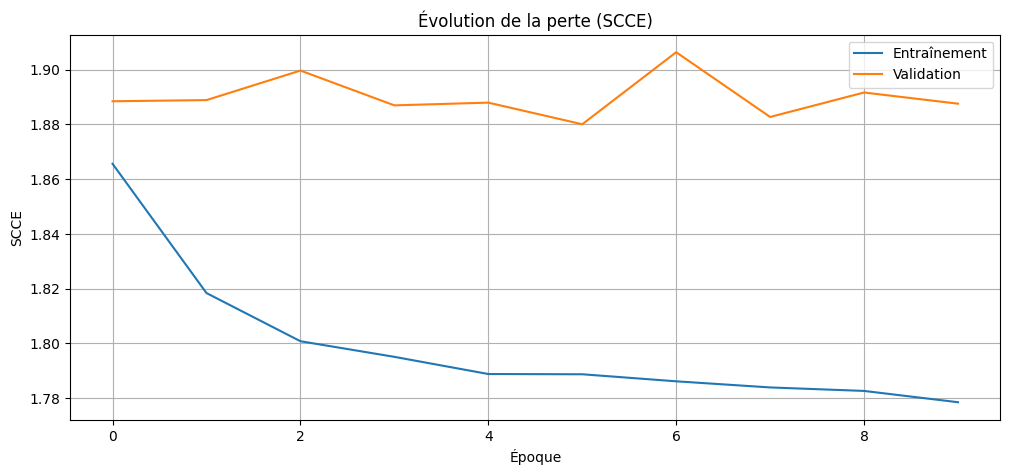

In [161]:
# Courbes d'entraînement et de validation
plt.figure(figsize=(12, 5))
plt.plot(history_TFT.history['loss'], label='Entraînement')
plt.plot(history_TFT.history['val_loss'], label='Validation')
plt.title('Évolution de la perte (SCCE)')
plt.xlabel('Époque')
plt.ylabel('SCCE')
plt.legend()
plt.grid(True)
plt.show()


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step


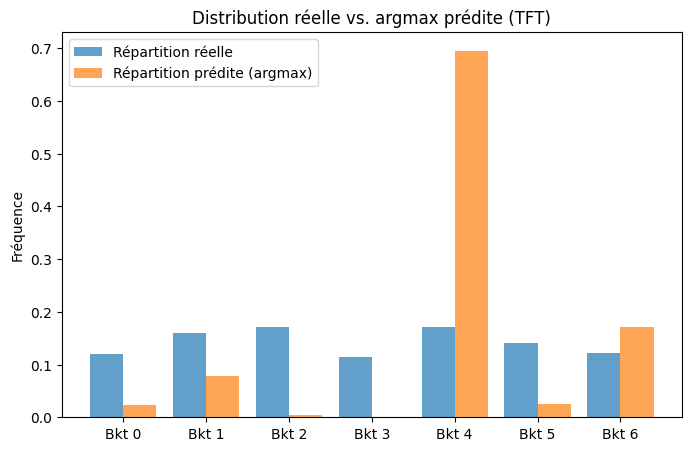

In [162]:
# Probabilités prédites (N_test_seq, n_buckets)
y_proba_TFT = model_TFT.predict(X_test_seq)
y_argmax_TFT = np.argmax(y_proba_TFT, axis=1)

true_counts = np.bincount(y_test_seq, minlength=n_buckets)
pred_counts = np.bincount(y_argmax_TFT, minlength=n_buckets)

true_freq = true_counts / true_counts.sum()
pred_freq = pred_counts / pred_counts.sum()

indices = np.arange(n_buckets)
bar_width = 0.4

plt.figure(figsize=(8,5))
plt.bar(indices - bar_width/2, true_freq, width=bar_width, alpha=0.7, label="Répartition réelle")
plt.bar(indices + bar_width/2, pred_freq, width=bar_width, alpha=0.7, label="Répartition prédite (argmax)")
plt.xticks(indices, [f"Bkt {i}" for i in indices])
plt.ylabel("Fréquence")
plt.title("Distribution réelle vs. argmax prédite (TFT)")
plt.legend()
plt.show()


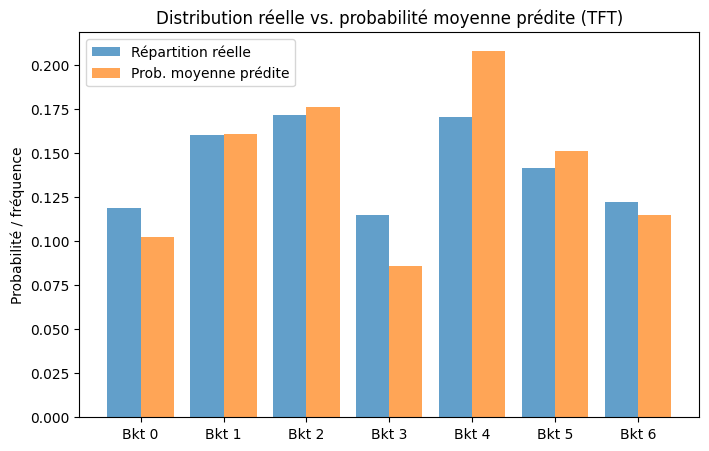

In [163]:
mean_proba = y_proba_TFT.mean(axis=0)  

plt.figure(figsize=(8,5))
plt.bar(indices - bar_width/2, true_freq, width=bar_width, alpha=0.7, label="Répartition réelle")
plt.bar(indices + bar_width/2, mean_proba, width=bar_width, alpha=0.7, label="Prob. moyenne prédite")
plt.xticks(indices, [f"Bkt {i}" for i in indices])
plt.ylabel("Probabilité / fréquence")
plt.title("Distribution réelle vs. probabilité moyenne prédite (TFT)")
plt.legend()
plt.show()
